# Summarizing the ASNE dataset

Instructions:

1. On hal9000, cd to ~/src/Alexis_Montserrat_codes.
2. run seisanwavdb2csv.py. This will create any missing ASNE_wavefilesYYYYMM.csv files. These have one line for each trace in each wavfile.
3. run count_traces_per_day.py. This will create ASNE_dailytraceid_wavfiles_df.csv. This has one line for each trrace, every day. 

There can be missing days, where there was no data. This is what we use the fill_missing_days_in_df function for.

Issues discovered so far:

* Sometimes with ASN WAV files we noticed that 1 file comes 1-s after another. Probably registered twice? Need to eliminate the duplicates.

* The gaps in the WAV file ontime plot doesn't appear to correspond to the gaps found. Indeed, the gaps seem a lot less than show, e.g. early 2004.

* I do not have a copy of the IRIG Seisan DB, which I made at MVO. It sounds like BGS have a copy, from reading Richard Luckett's report. I believe this was all the data from XDETECT that I originally converted in 2001, after it was phased out.

* It appears that ASNE data (converted in 2015) are 4 hours behind SPN data (which we triggered in real-time by QNX, and appear to match DSN (MVO) data. This has only been seen in late March 2001 so far, which was after the transition. 

Possibilities:

1. All ASNE WAV files have a timestamp that is too great by 4 hours. This seems possible if a 4 hour time correction was ever applied during my 2015 conversions. Were XDETECT files were timestamped with UTC or local time? Logbooks likely matched. So they might all have been UTC! If I have inadvertently added 4 hours to all ASNE WAV files, this means that new S-files that students are generating are off by 4 hours also. This is the worst case scenario. But it is also possible that XDETECT used localtime, in which case I did need to apply a 4 hour correction. Could I have applied the time correction twice?

2. Only ASNE data after mid-March 2001 is off by 4 hours. I might have applied some blanket time correction to the data deriving from XDETECT (appropriate) and also from QNX Seislog (mistake). In this case I can probably throw away all ASN files after mid-March 2001 and use SPN files instead.



ASN waveform data was converted 3 times:

    2001: 
    
    I had copies of IRIG.EXE, DEMUX.EXE from UEA Belham project I think?. and I modified sudsei.for from Seisan so that I could drive it from the command line. So I constructed Perl script to loop over all year/month directories of SUDS data, and time correct, demutiplex and convert to Seisan. I thought I even went through and associated all IRIG files into the MVOE database. I wonder where my original copy of the MVO REA/MVOE_ database went?
        
    2015:
        
    I used PC-SUDS or WIN-SUDS (which contained IRIG.EXE and DEMUX.EXE) and CONVSEIS (SUDS2GSE.EXE). So a Perl script on a 32-bit Windows PC was able to convert everything to GSE-1 format. And then I wrote ObsPy script to convert everything to Miniseed. Miniseed files were organized into an Antelope database, and then included when building an SDS archive of the combined networks.
    
    2019: 
    
    For the student project, I copied the ASN Miniseed event waveform data into a Seisan DB called ASNE. I also tested if conversion still worked, and on a 64-bit Dinwso 10 PC was able to run PC-SUDS DEMUX.EXE and SUD2MSED.EXE to convert some SUDS WVM to SUDS DMX and MiniSEED files.

In [72]:
import pandas as pd
import csv
import obspy
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import datetime as dt

def get_yticks(thisdf):
    yticklabels = []
    yticks=[]
    i = 0
    for index, row in thisdf.iterrows():
        date = str(index)
        if date[-2:]=='01':
            yticklabels.append(date)
            yticks.append(i)
        i+=1
    ystep = 1
    if len(yticks)>15:
        ystep=2  
    if len(yticks)>25:
        ystep=3
    if len(yticks)>40:
        ystep=4
    if len(yticks)>60:
        ystep=6
    if len(yticks)>120:
        ystep=12    
    yticks = yticks[0::ystep]
    yticklabels = yticklabels[0::ystep]
    return (yticks, yticklabels)

def ontime_plot(data,xticklabels,yticks,yticklabels):
    # make ontime plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(data, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
    plt.xticks(np.arange(len(xticklabels)), xticklabels)
    ax.set_xticklabels(xticklabels, rotation = 90)
    plt.yticks(yticks, yticklabels)
    plt.tight_layout()
    return (fig, ax)

def numrunningperday_plot(data, yticks, yticklabels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    s = np.sum(data,axis=1)
    plt.plot(s,'.')
    plt.xticks(yticks, yticklabels)
    ax.set_xticklabels(yticklabels, rotation = 90)
    return (fig, ax)

def intday2date(intday):
    ymd = str(intday)
    d = dt.date(int(ymd[0:4]),int(ymd[4:6]),int(ymd[6:8]))
    return d

def fill_missing_days_in_df(df, startday=19950726, endday=20041231):
    # need to make sure that every date from start to end exists in sites_df
    cols = list(df.columns)
    lastd = intday2date(startday)
    totalmissingdays = 0
    for index, row in df.iterrows():
        try:
            ymd = str(index)
        except:
            continue
        d = intday2date(ymd)
        daysdiff = (d-lastd).days
        if daysdiff > 1:
            totalmissingdays += daysdiff - 1
            print(daysdiff,' days missing between', lastd, ' and ', d)
            for d1 in range(1,daysdiff):
                missingday = lastd + dt.timedelta(days=d1)
                missingindex = int(missingday.strftime('%Y%m%d'))
                for col in cols:
                    df.at[missingindex,col]=0
                #missingdict = {'date':), \
                #    'BE':0, 'CP':0, 'GA':0, 'GH':0, 'GT':0, 'HR':0, 'JH':0, 'LG':0, \
                #    'LY':0, 'MVO':0, 'NEV':0, 'PL':0, 'RY':0, 'SA':0, 'SP':0, 'SS':0, \
                #    'VP':0, 'WH':0}
            #df = df.append(missingdict, ignore_index=True)
        lastd = d
    endd = intday2date(endday)   
    if lastd < endd:
        daysdiff = (endd-lastd).days
        for d1 in range(1,daysdiff+1):
            missingday = lastd + dt.timedelta(days=d1)
            missingindex = int(missingday.strftime('%Y%m%d'))
            for col in cols:
                df.at[missingindex,col]=0
    return(df.sort_index())

def translate_id2site(id):
    if len(id)==4:
        id = 'MV.%s' % id
    thissite = id[4:6]
    if id[3:7]=='LONG':
        thissite = 'LG'
    if id[3:5]=='MW':
        thissite = 'WH'
    if id[3:6]=='MVO':
        thissite = 'MVO'
    if id[4:7]=='NEV':
        thissite = 'NEV'
    if id[3:5]=='MP':
        thissite = 'PL'
    if id[3:6]=='MCH':
        thissite = 'CP'
    if id[3:7]=='IRIG' or id[3:7]=='TST1' or id[3:6]=='MRH':
        thissite = ''
    return thissite    

def stationids2sites(uniqids):
    sites = set()
    for id in uniqids:
        thissite = translate_id2site(id)
        if not thissite:
            continue
        sites.add(thissite)
    sites = sorted(sites)
    return sites

Load in CSV file which has the number of events for each traceid each day
Columns are yyyymmdd traceid count

In [80]:
csvfile = '/home/thompsong/src/Alexis_Montserrat_codes/ASNE_dailytraceid_wavfiles_df.csv'
trace_df = pd.read_csv(csvfile)
trace_df = trace_df[['yyyymmdd','traceid','count']]
trace_df = trace_df.set_index('yyyymmdd')
print(trace_df.head())
print(trace_df.tail())

                 traceid  count
yyyymmdd                       
19950701  MV.MVPZ.--.SHZ      0
19950701  MV.MWHE.--.SHE      0
19950701  MV.MCPT.--.SHZ      0
19950701  MV.MVOV.--.SHY      0
19950701  MV.MGAT.--.SHZ      0
                 traceid  count
yyyymmdd                       
20041231  MV.MWHN.--.SHX      0
20041231  MV.MHRE.--.SHX      0
20041231  MV.MPVE.--.SHZ      0
20041231  MV.MWHT.--.SHZ      0
20041231  MV.MPLX.--.SHE      0


In [84]:
uniqids = sorted(trace_df.traceid.unique())
station_ids = list(filter(lambda x: 'MV.M' in x, uniqids))
print(station_ids)

['MV.MBET.--.SHZ', 'MV.MCHT.--.SHZ', 'MV.MCPE.--.SHX', 'MV.MCPN.--.SHY', 'MV.MCPN.--.SHZ', 'MV.MCPT.--.SHZ', 'MV.MCPZ.--.SHY', 'MV.MCPZ.--.SHZ', 'MV.MGAT.--.SHZ', 'MV.MGHZ.--.SHZ', 'MV.MGT2.--.SHZ', 'MV.MHRE.--.SHX', 'MV.MHRE.--.SHZ', 'MV.MHRN.--.SHX', 'MV.MHRN.--.SHY', 'MV.MHRV.--.SHY', 'MV.MHRV.--.SHZ', 'MV.MJHL.--.SHZ', 'MV.MJHT.--.SHZ', 'MV.MLGL.--.SHE', 'MV.MLGL.--.SHZ', 'MV.MLGT.--.SHZ', 'MV.MLYT.--.SHZ', 'MV.MNEV.--.SHZ', 'MV.MPEW.--.SHE', 'MV.MPEW.--.SHZ', 'MV.MPLX.--.SHE', 'MV.MPLY.--.SHN', 'MV.MPLZ.--.SHZ', 'MV.MPNS.--.SHN', 'MV.MPVE.--.SHZ', 'MV.MRHT.--.SHZ', 'MV.MRYT.--.SHZ', 'MV.MSAT.--.SHZ', 'MV.MSPT.--.SHZ', 'MV.MSSE.--.SHX', 'MV.MSSN.--.SHY', 'MV.MSSZ.--.SHZ', 'MV.MVOE.--.SHZ', 'MV.MVON.--.SHX', 'MV.MVOV.--.SHY', 'MV.MVPE.--.SHE', 'MV.MVPE.--.SHX', 'MV.MVPN.--.SHY', 'MV.MVPV.--.SHZ', 'MV.MVPZ.--.SHZ', 'MV.MWEH.--.SHX', 'MV.MWEL.--.SHX', 'MV.MWH2.--.SHZ', 'MV.MWHE.--.SHE', 'MV.MWHE.--.SHX', 'MV.MWHE.--.SHY', 'MV.MWHN.--.SHN', 'MV.MWHN.--.SHX', 'MV.MWHN.--.SHY', 'MV.MWHT.

In [88]:
station_df = pd.DataFrame(columns = ['date'] + station_ids)
for index, row in trace_df.iterrows():
    #thisdate = row['yyyymmdd']
    thisdate = index
    thissta = row['traceid']
    thiscount = row['count']
    if np.isnan(thiscount):
        thiscount = 0
    station_df.at[thisdate,thissta] = thiscount
        
# Drop date column and fill missing days        
station_df = station_df.drop(columns=['date'])
station_df = fill_missing_days_in_df(station_df)


32  days missing between 2002-09-30  and  2002-11-01
31  days missing between 2003-03-31  and  2003-05-01


Text(0.5,6.8,'Station')

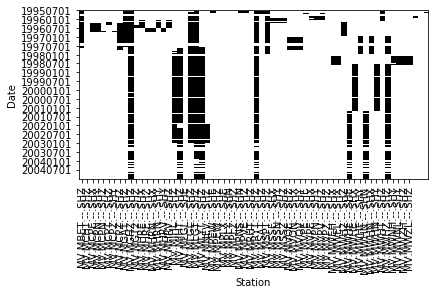

In [91]:
station_bool_df = (station_df > 0) * 1
station_bool_data = np.array(station_bool_df, dtype=float) # convert dataframe to numpy array
xticklabels = station_ids
(yticks, yticklabels) = get_yticks(station_bool_df)
(fig, ax) = ontime_plot(1-station_bool_data,xticklabels,yticks,yticklabels)
plt.savefig('ASNE_station_ontime.png',dpi=300)
plt.ylabel('Date')
plt.xlabel('Station')

loop over rows in df, and create a new dataframe for sites, with a 1 to indicate if on for each day

In [92]:
uniqids = df.traceid.unique()
sites = stationids2sites(uniqids)
sites_df = pd.DataFrame(columns = ['date'] + sorted(sites))
for index, row in trace_df.iterrows():
    #thisdate = row['yyyymmdd']
    thisdate = index
    thissite = translate_id2site(row['traceid'])
    if not thissite:
        continue
    thiscount = row['count']
    if np.isnan(thiscount):
        thiscount = 0
    currentcount = 0
    try:
        currentcount = sites_df.at[thisdate,thissite]
    except:
        pass
    if np.isnan(currentcount):
        currentcount = 0
    if thiscount > currentcount:
        sites_df.at[thisdate,thissite] = thiscount
        
# Drop date column and fill missing days        
sites_df = sites_df.drop(columns=['date'])
sites_df = fill_missing_days_in_df(sites_df)
print(sites_df.head())
print(sites_df.tail())

19  days missing between 1995-09-22  and  1995-10-11
2  days missing between 1995-10-11  and  1995-10-13
4  days missing between 1995-10-13  and  1995-10-17
6  days missing between 1995-10-17  and  1995-10-23
15  days missing between 1995-10-23  and  1995-11-07
16  days missing between 1995-11-15  and  1995-12-01
2  days missing between 1996-02-06  and  1996-02-08
5  days missing between 1996-02-10  and  1996-02-15
8  days missing between 1996-02-15  and  1996-02-23
3  days missing between 1996-02-23  and  1996-02-26
2  days missing between 1996-02-26  and  1996-02-28
3  days missing between 1996-02-28  and  1996-03-02
2  days missing between 1996-03-03  and  1996-03-05
2  days missing between 1996-03-09  and  1996-03-11
2  days missing between 1996-03-11  and  1996-03-13
2  days missing between 1996-04-09  and  1996-04-11
9  days missing between 1996-04-11  and  1996-04-20
12  days missing between 1997-03-20  and  1997-04-01
3  days missing between 1997-05-01  and  1997-05-04
6  days 

Text(0.5,6.8,'Site')

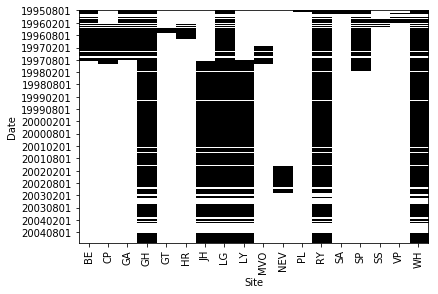

In [93]:
sites_bool_df = (sites_df > 0) * 1
sites_bool_data = np.array(sites_bool_df, dtype=float) # convert dataframe to numpy array
xticklabels = sites
(yticks, yticklabels) = get_yticks(sites_bool_df)
(fig, ax) = ontime_plot(1-sites_bool_data,xticklabels,yticks,yticklabels)
plt.savefig('ASNE_siteontime.png',dpi=300)
plt.ylabel('Date')
plt.xlabel('Site')

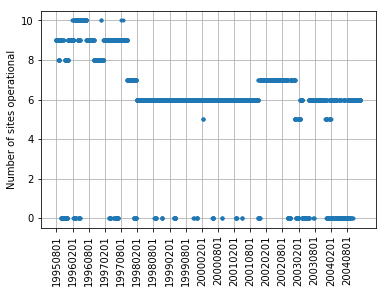

In [94]:
(fig, ax) = numrunningperday_plot(sites_bool_data, yticks, yticklabels)    
plt.ylabel('Number of sites operational')
plt.grid()
plt.savefig('ASNE_numsitesperday.png',dpi=300)

(3446, 18)
total # wavefiles = 230645


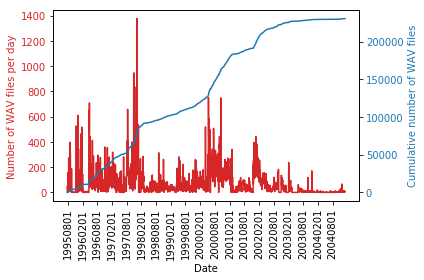

In [95]:
sites_data = np.array(sites_df) # convert dataframe to numpy array
print(sites_data.shape)
y = np.nanmax(sites_data,axis=1)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of WAV files per day', color=color)
ax1.plot(y, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(yticks, yticklabels)
ax1.set_xticklabels(yticklabels, rotation = 90)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Cumulative number of WAV files', color=color)  # we already handled the x-label with ax1
ax2.plot(np.cumsum(y), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()
plt.savefig('ASNE_numwavfilesperday.png',dpi=300)
print('total # wavefiles = %d' % np.sum(y))

# Evaluate the amount of RSAM data captured

RSAM_data_captured.m was written on iMac in Documents/MATLAB to make a summary of what fraction of RSAM data was collected for each station and for each day of the ASN. This generated files like RSAM_MBET.txt consisting of two columns: date (yyyymmdd) \t  MBET

Next we read in all these files, and create a dataframe from merging all of them

In [34]:
rsamtxtfiles = sorted(glob.glob('/media/imacdocuments/MATLAB/RSAM_????.txt'))
count = 0
for rsamfile in rsamtxtfiles:
    rsamdf=pd.read_csv(rsamfile,sep='\t')
    if count == 0:
        rsamdf_all = rsamdf
    else:
        rsamdf_all = pd.merge(rsamdf_all, rsamdf, on='date')
    count += 1
rsamdf_all = rsamdf_all.set_index('date')
print(rsamdf_all.head())
print(rsamdf_all.tail())
rsamdf_all = fill_missing_days_in_df(rsamdf_all, startday=19950728, endday=20040110)


          MBET  MCPT  MCPZ  MGAT  MGHZ  MHRE  MHRN  MHRV  MJHL  MJHT  ...   \
date                                                                  ...    
19950728  0.45   0.0   0.0  0.45  0.45   0.0   0.0   0.0   0.0   0.0  ...    
19950729  1.00   0.0   0.0  1.00  1.00   0.0   0.0   0.0   0.0   0.0  ...    
19950730  1.00   0.0   0.0  1.00  1.00   0.0   0.0   0.0   0.0   0.0  ...    
19950731  1.00   0.0   0.0  1.00  1.00   0.0   0.0   0.0   0.0   0.0  ...    
19950801  1.00   0.0   0.0  1.00  1.00   0.0   0.0   0.0   0.0   0.0  ...    

          MWEL  MWH2  MWHE  MWHN  MWHT  MWHZ  MWNH  MWNL  MWZH  MWZL  
date                                                                  
19950728   0.0   0.0   0.0   0.0  0.45   0.0   0.0   0.0   0.0   0.0  
19950729   0.0   0.0   0.0   0.0  1.00   0.0   0.0   0.0   0.0   0.0  
19950730   0.0   0.0   0.0   0.0  1.00   0.0   0.0   0.0   0.0   0.0  
19950731   0.0   0.0   0.0   0.0  1.00   0.0   0.0   0.0   0.0   0.0  
19950801   0.0   0.0   0.0 

Create plots summarizing how much RSAM data captured

Text(0.5,6.8,'Station')

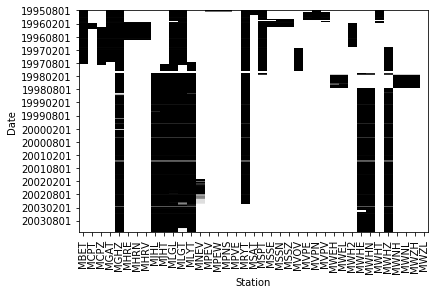

In [52]:
data_rsam = np.array(rsamdf_all, dtype=float) # convert dataframe to numpy array
xticklabels = rsamdf_all.columns
(yticks, yticklabels) = get_yticks(rsamdf_all)
(fig, ax) = ontime_plot(1-data_rsam,xticklabels,yticks,yticklabels)
plt.savefig('RSAMontime.png',dpi=300)
plt.ylabel('Date')
plt.xlabel('Station')

          MBET  MCPT  MCPZ  MGAT  MGHZ  MHRE  MHRN  MHRV  MJHL  MJHT  ...   \
date                                                                  ...    
19950728  0.45   0.0   0.0  0.45  0.45   0.0   0.0   0.0   0.0   0.0  ...    
19950729  1.00   0.0   0.0  1.00  1.00   0.0   0.0   0.0   0.0   0.0  ...    
19950730  1.00   0.0   0.0  1.00  1.00   0.0   0.0   0.0   0.0   0.0  ...    
19950731  1.00   0.0   0.0  1.00  1.00   0.0   0.0   0.0   0.0   0.0  ...    
19950801  1.00   0.0   0.0  1.00  1.00   0.0   0.0   0.0   0.0   0.0  ...    

          MWEL  MWH2  MWHE  MWHN  MWHT  MWHZ  MWNH  MWNL  MWZH  MWZL  
date                                                                  
19950728   0.0   0.0   0.0   0.0  0.45   0.0   0.0   0.0   0.0   0.0  
19950729   0.0   0.0   0.0   0.0  1.00   0.0   0.0   0.0   0.0   0.0  
19950730   0.0   0.0   0.0   0.0  1.00   0.0   0.0   0.0   0.0   0.0  
19950731   0.0   0.0   0.0   0.0  1.00   0.0   0.0   0.0   0.0   0.0  
19950801   0.0   0.0   0.0 

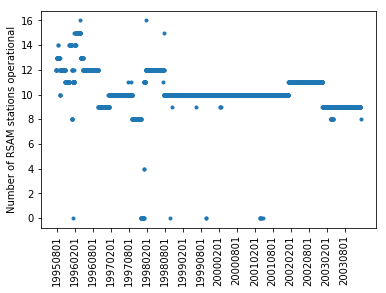

In [53]:
booldata_rsam = (data_rsam > 0) * 1
(fig, ax) = numrunningperday_plot(booldata, yticks, yticklabels)    
plt.ylabel('Number of RSAM stations operational')
plt.savefig('RSAM_numstationsperday.png',dpi=300)
print(rsamdf_all.head())

In [37]:
rsamstations = list(xticklabels)
rsamsites = stationids2sites(rsamstations)
print(rsamsites)

['BE', 'CP', 'GA', 'GH', 'HR', 'JH', 'LG', 'LY', 'MVO', 'NEV', 'PL', 'RY', 'SA', 'SP', 'SS', 'VP', 'WH']


In [104]:
# loop over rows in df, and create a new dataframe for sites, with a 1 to indicate if on for each day
rsamsites_df = pd.DataFrame(columns = ['date'] + sorted(rsamsites))
for index, row in rsamdf_all.iterrows():
    for sta in rsamstations:
        thisdate = index #row['date']
        thissite = translate_id2site(sta)
        #print(sta,thissite)
        
        if not thissite:
            continue
        thiscount = row[sta]
        if np.isnan(thiscount):
            thiscount = 0
        currentcount = 0
        try:
            currentcount = rsamsites_df.at[thisdate,thissite]
        except:
            pass
        if np.isnan(currentcount):
            currentcount = 0
        if thiscount > currentcount:
            rsamsites_df.at[thisdate,thissite] = thiscount
rsamsites_df = fill_missing_days_in_df(rsamsites_df, startday=19950728, endday=20040110)
print(rsamsites_df)

2  days missing between 1996-01-10  and  1996-01-12
30  days missing between 1997-12-03  and  1998-01-02
2  days missing between 1998-09-20  and  1998-09-22
2  days missing between 1999-09-25  and  1999-09-27
2  days missing between 1999-09-28  and  1999-09-30
2  days missing between 2001-03-21  and  2001-03-23
5  days missing between 2001-03-29  and  2001-04-03
2  days missing between 2001-04-28  and  2001-04-30
         date    BE   CP    GA    GH   HR    JH    LG    LY  MVO  NEV    PL  \
19950728  NaN  0.45  NaN  0.45  0.45  NaN   NaN  0.45   NaN  NaN  NaN  0.45   
19950729  NaN     1  NaN     1     1  NaN   NaN     1   NaN  NaN  NaN     1   
19950730  NaN     1  NaN     1     1  NaN   NaN     1   NaN  NaN  NaN     1   
19950731  NaN     1  NaN     1     1  NaN   NaN     1   NaN  NaN  NaN     1   
19950801  NaN     1  NaN     1     1  NaN   NaN     1   NaN  NaN  NaN     1   
19950802  NaN     1  NaN     1     1  NaN   NaN     1   NaN  NaN  NaN     1   
19950803  NaN     1  NaN     1

Text(0.5,6.8,'Site')

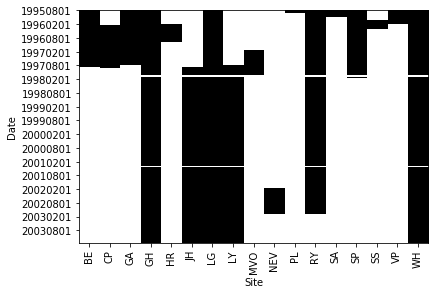

In [65]:
rsamsites_bool_df = (rsamsites_df > 0) * 1
data_rsam_sites = np.array(rsamsites_bool_df, dtype=float) # convert dataframe to numpy array
xticklabels = rsamsites
(yticks, yticklabels) = get_yticks(rsamsites_bool_df)
(fig, ax) = ontime_plot(1-data_rsam_sites[:,1:],xticklabels,yticks,yticklabels)
plt.savefig('RSAM_siteontime.png',dpi=300)
plt.ylabel('Date')
plt.xlabel('Site')

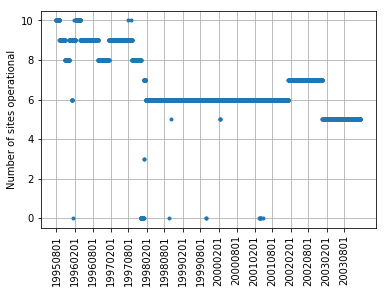

In [67]:
(fig, ax) = numrunningperday_plot(data_rsam_sites, yticks, yticklabels)    
plt.ylabel('Number of sites operational')
plt.grid()
plt.savefig('RSAM_numsitesperday.png',dpi=300)

# TILT data analysis

In [102]:
tilttxtfiles = sorted(glob.glob('/media/imacdocuments/MATLAB/TILT_????.txt'))
count = 0
for tiltfile in tilttxtfiles:
    tiltdf=pd.read_csv(tiltfile,sep='\t')
    if count == 0:
        tiltdf_all = tiltdf
    else:
        tiltdf_all = pd.merge(tiltdf_all, tiltdf, on='date')
    count += 1
tiltdf_all = tiltdf_all.set_index('date')
print(tiltdf_all.head())
print(tiltdf_all.tail())
tiltdf_all = fill_missing_days_in_df(tiltdf_all, startday=19950727, endday=20001006)


          AMER  CENT  CHP2  CHP3  CHPK  GAGE  HERM  LONG  PRNG
date                                                          
19950728  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.00
19950729  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.00
19950730  0.03   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.31
19950731  0.40   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.99
19950801  0.32   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.99
          AMER  CENT  CHP2  CHP3  CHPK  GAGE  HERM  LONG  PRNG
date                                                          
20040106   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
20040107   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
20040108   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
20040109   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
20040110   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0


Text(0.5,6.8,'Station')

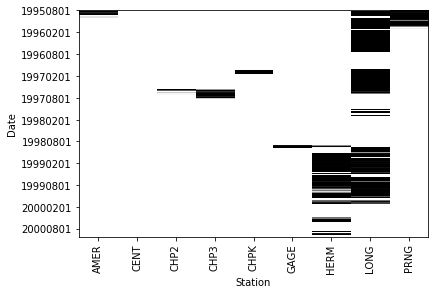

In [103]:
tiltdf_all = tiltdf_all[tiltdf_all.index <= 20001006] 
data_tilt = np.array(tiltdf_all, dtype=float) # convert dataframe to numpy array

xticklabels = tiltdf_all.columns
(yticks, yticklabels) = get_yticks(tiltdf_all)
(fig, ax) = ontime_plot(1-data_tilt,xticklabels,yticks,yticklabels)
plt.savefig('TILT_ontime.png',dpi=300)
plt.ylabel('Date')
plt.xlabel('Station')

# to-do


# ASN Catalog data
Make a plot of subplots of:
(1) Number of cumulative located events
(2) Cumulative energy plot
(3) Number of cumulative pickfiles
(4) Number of classified events vs WAV files (possibly just July 1995 - October 1996)


# RSAM EVENTS, ALARMS AND SSAM DATA

Plots of:

(1) cumulative RSAM alarms vs day (done)
(2) cumulative RSAM events (or triggers?) vs day
(3) SSAM data?

Leave for later the task of making use of the amplitude data, or associating triggers.


# DSN data

With the DSN data, we want to do similar things regarding DSNC_, BSAM and DSNE_ (MVOE_)

# Merged data
(1) Minutes per day of data at each site?
(2) got to merge the ASN and DSN catalogs properly